In [1]:
import glob
import os
import librosa
import numpy as np
import seaborn as sns
import wave
import contextlib
import pandas as pd

from sklearn.metrics import accuracy_score,classification_report,f1_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

# Features plots - Code

In [2]:
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot',x=0.5, y=0.915,fontsize=18)
    plt.show()
    
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log power spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

# Extracting features

In [3]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    #print(chroma.shape)
    #print("chroma")
    #print(mfccs.shape)
    #print("mfccs")
    #print(mel.shape)
    #print("mels")
    #print(contrast.shape)
    #print("contrast")
    #print(tonnetz.shape)
    #print("tonnetz")    
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    d=0
    duration1 = []
    duration2 = []
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir,sub_dir,file_ext)):
            with contextlib.closing(wave.open(fn,'r')) as f:
                frames = f.getnframes()
                rate = f.getframerate()
                duration = frames / float(rate)
                print(pd.Series(fn.split('_')).unique())
                print(d,duration)
                d=d+1
                print(" ")
                #dn=0
                if(sub_dir!='noise_set'):
                    #if(duration<0):
                    #    dn =dn+1
                    duration1.append(duration)  
                else:
                    duration2.append(duration)
            
    return duration1,duration2

In [4]:
def parse_audio_files2(parent_dir,sub_dirs,file_ext='*.wav'):
    features = np.empty((0,193))
    finlabel = np.empty((0,3))
    labells=[]
    labells1=np.empty(0) 
    labells2=np.empty(0) 
    d=0
    fns = []
    labels=[]
    label1s=[]
    label2s=[]
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir,sub_dir,file_ext)):
            mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
          #  print("ext_features")
          #  print(ext_features.shape)
            features = np.vstack([features,ext_features])
          #  print("features")
          #  print(features.shape)
            if(sub_dir!='noise_set'):
                    d = d+1
                    if (len(fn.split('_'))>=6):
                        label1 = "1"
                    else:
                        label1="0"
                    label="1"
                    if(sub_dir=='TRIM_old'):
                        if(fn.split('_')[-1]=='2.wav' ):
                            label2="2"
                        if(fn.split('_')[3]=='Multiplepeacock'):
                            label2 = "4"
                        else:
                            label2 ="1"
                    else:
                        if(fn.split('_')[-1]=='1.wav'):
                            label2="1"
                        elif(fn.split('_')[-1]=='2.wav'):
                            label2 ="2" 
                        elif(fn.split('_')[-1]=='3.wav'):
                            label2 ="3"
                        elif(fn.split('_')[-1]=='MI.wav' or fn.split('_')[-1]=='3or4.wav'):
                            label2 ="4"                        
                        else:
                            label2 ="0"
                            
            else:
                label ="0"
                label1="1"
                label2 ="0"
            fns.append(fn.split('_')[1:])
            use = np.hstack([label,label1,label2])
            finlabel = np.vstack([finlabel,use])
            labels.append(label)
            label1s.append(label1)
            label2s.append(label2)
    return(fns, np.array(features), np.array(finlabel),np.array(labels), np.array(label1s), np.array(label2s))

> #  Feed Train & Test Data 

In [5]:
parent_dir = '../input/data-w/data/data'

sub_dirs = ['C_new2','TRIM_old','A_new1','trimmed_new3','noise_set','Chincholi','iid','Kaan'] #train dirs
duration1,duration2= parse_audio_files(parent_dir,sub_dirs)

['../input/data-w/data/data/C' 'new2/20' 'Eow' 'peacock' 'disturbance'
 '2.wav']
0 4.841
 
['../input/data-w/data/data/C' 'new2/05' 'ka' 'peacock' '1.wav']
1 0.424
 
['../input/data-w/data/data/C' 'new2/01' 'Eow' 'peacock' 'disturbance'
 '2.wav']
2 0.7433125
 
['../input/data-w/data/data/C' 'new2/15' 'Eow' 'peacock' 'disturbance'
 '2.wav']
3 7.42875
 
['../input/data-w/data/data/C' 'new2/02' 'Eow' 'peacock' '1.wav']
4 3.74271875
 
['../input/data-w/data/data/C' 'new2/35' 'Eow' 'peacock' 'disturbance'
 '2.wav']
5 6.885625
 
['../input/data-w/data/data/C' 'new2/03' 'SN' 'peacock' 'disturbance'
 '2.wav']
6 0.36378125
 
['../input/data-w/data/data/C' 'new2/19' 'SN' 'peacock' '1.wav']
7 0.4014375
 
['../input/data-w/data/data/C' 'new2/26' 'SN' 'peacock' '1.wav']
8 0.33846875
 
['../input/data-w/data/data/C' 'new2/17' 'Eow' 'peacock' 'disturbance'
 '2.wav']
9 7.5035625
 
['../input/data-w/data/data/C' 'new2/30' 'SN' 'peacock' '1.wav']
10 0.283375
 
['../input/data-w/data/data/C' 'new2/16' 'S

In [6]:
dafr = pd.DataFrame()
dafr["peacock_audio_durations"] = pd.Series(duration1)
dafr["noise_durations"] = pd.Series(duration2)

# Data Distribution

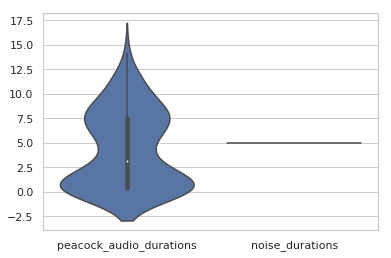

In [7]:
sns.set(style="whitegrid")
ax = sns.violinplot(data=dafr)

In [8]:
fn,features,final_labels,label,label1,label2 = parse_audio_files2(parent_dir,sub_dirs)

/opt/conda/lib/python3.6/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/opt/conda/lib/python3.6/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/opt/conda/lib/python3.6/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/opt/conda/lib/python3.6/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag expli

In [9]:
final_labels.shape

(1242, 3)

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer,LabelBinarizer
from numpy import argmax
from keras.utils import to_categorical
from keras import initializers

one_hot1 = LabelBinarizer()
# One-hot encode data
label_ = one_hot1.fit_transform(label)
label_1 = one_hot1.fit_transform(label1)
#print(one_hot1.classes_)print(label_)print(label_1)
one_hot2 = MultiLabelBinarizer()
# One-hot encode data
label_2 = one_hot2.fit_transform(label2)
label__2 = to_categorical(label2)
#print(label__2)
one_hot2.classes_

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

array(['0', '1', '2', '3', '4'], dtype=object)

In [11]:
print(label__2.shape)
print(label_1.shape)
print(label_.shape)
print(label_2.shape)

(1242, 5)
(1242, 1)
(1242, 1)
(1242, 5)


In [12]:
dafr_labels = pd.DataFrame()
dafr_labels["file_name"] = fn
dafr_labels["peacock"] = label_
dafr_labels["disturbance"] = label_1
#dafr_labels["single_peacock"] = [label__2]

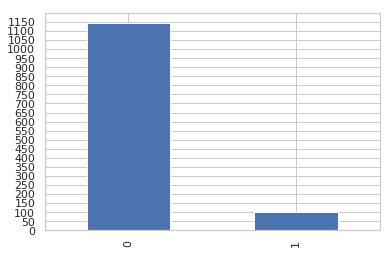

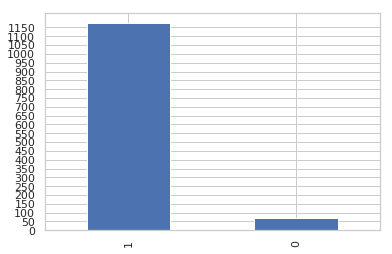

In [13]:
dafr_labels['peacock'].value_counts().plot(kind='bar')
            #,'disturbance','single_peacock']].plot(kind='bar')
#plt.xticks(np.arange(0, 51, 5)) 
plt.yticks(np.arange(0, 1200, 50)) 
plt.show()
dafr_labels['disturbance'].value_counts().plot(kind='bar')
plt.yticks(np.arange(0, 1200, 50)) 
plt.show()
#dafr_labels['single_peacock'].value_counts().plot(kind='bar')
#plt.yticks(np.arange(0, 1200, 25)) 
#plt.show()

In [14]:
pd.Series(label).value_counts()

0    1143
1      99
dtype: int64

In [15]:
pd.Series(label1).value_counts()

1    1174
0      68
dtype: int64

In [16]:
pd.Series(label2).value_counts()

0    1146
1      48
2      41
4       4
3       3
dtype: int64

# MLP keras 

In [17]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten, Dropout, BatchNormalization

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D
#from keras import regularizers, optimizer
import pandas as pd
import random
import tensorflow as tf
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,multilabel_confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras import backend as K
random.seed(42)
np.random.seed(42)
tf.set_random_seed(42)

my_init = initializers.glorot_uniform(seed=42)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [18]:
X_train, X_test, y1_train, y1_test,y2_train,y2_test,y3_train,y3_test = train_test_split(features,
                                            label_,label_1,label__2, test_size=0.33, random_state=42)

In [19]:
print(y3_train.shape)
print(y3_test.shape)

(832, 5)
(410, 5)


## Multi output neural network

In [20]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [22]:
#create the model
inn = Input(shape = (193,))
x = Sequential()(inn)
# Adding the input layer and the first hidden layer
x = Dense(output_dim = 40, init = 'uniform', activation = 'relu', input_dim = 193)(x)
# Adding the second hidden layer
x=Dense(output_dim = 20, init = 'uniform', activation = 'relu')(x)
x= Dense(output_dim = 8, init = 'uniform', activation = 'relu')(x)
# Adding the output layer
out1 =Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid')(x)
out2 =Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid')(x)
out3 =Dense(output_dim = 5, init = 'uniform', activation = 'softmax')(x)
# Compiling Neural Network
model = Model(inputs=[inn], outputs=[out1, out2,out3])
#classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# compile the model
model.compile(optimizer='adam', loss=['binary_crossentropy','binary_crossentropy','categorical_crossentropy'],
              metrics=[f1_m,f1_m,f1_m])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=193, units=40, kernel_initializer="uniform")`
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=20, kernel_initializer="uniform")`
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=8, kernel_initializer="uniform")`
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid",

In [23]:
class_weights = {0: 1.08377,
                1: 25.875,
                2: 30.3,
                3: 414,
                4: 310.5} # w(i) = N/n(i)
cw1 = {0:1.,
       1:10.} 
cw2 = {0:10.,
       1:1.} 

In [24]:
# fit the model
history = model.fit(X_train, [y1_train,y2_train,y3_train],
                    validation_split=0.3, epochs=100,batch_size = 10, verbose=1,class_weight=[cw1,cw2,class_weights])

Train on 582 samples, validate on 250 samples
Epoch 1/100
582/582 [==============================] - 3s 5ms/step - loss: 8.9964 - dense_4_loss: 1.1681 - dense_5_loss: 0.9665 - dense_6_loss: 6.8618 - dense_4_f1_m: 0.0734 - dense_4_f1_m_1: 0.0734 - dense_4_f1_m_2: 0.0734 - dense_5_f1_m: 0.9498 - dense_5_f1_m_1: 0.9498 - dense_5_f1_m_2: 0.9498 - dense_6_f1_m: 0.0276 - dense_6_f1_m_1: 0.0276 - dense_6_f1_m_2: 0.0276 - val_loss: 10.9308 - val_dense_4_loss: 1.0396 - val_dense_5_loss: 0.9322 - val_dense_6_loss: 8.9590 - val_dense_4_f1_m: 0.0000e+00 - val_dense_4_f1_m_1: 0.0000e+00 - val_dense_4_f1_m_2: 0.0000e+00 - val_dense_5_f1_m: 0.9675 - val_dense_5_f1_m_1: 0.9675 - val_dense_5_f1_m_2: 0.9675 - val_dense_6_f1_m: 0.2719 - val_dense_6_f1_m_1: 0.2719 - val_dense_6_f1_m_2: 0.2719
Epoch 2/100
582/582 [==============================] - 1s 1ms/step - loss: 7.9660 - dense_4_loss: 0.9488 - dense_5_loss: 0.7037 - dense_6_loss: 6.3134 - dense_4_f1_m: 0.0000e+00 - dense_4_f1_m_1: 0.0000e+00 - dense_4

In [25]:
# evaluate the model
f1score = model.evaluate(X_test, [y1_test,y2_test,y3_test])
#classifier =KerasClassifier(build_fn=making_model(193), epochs=100, batch_size=10, verbose=0)

410/410 [==============================] - 0s 245us/step


In [26]:
#f1score

In [27]:
yy1,yy2,yy3 = model.predict(X_test)

In [28]:
shape = yy3.shape
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        if yy3[i, j] >= 0.5:
            yy3[i, j] = 1
        else:
            yy3[i, j] = 0
for i in range(0, shape[0]):
        if yy2[i, 0] >= 0.5:
            yy2[i, 0] = 1
        else:
            yy2[i, 0] = 0
for i in range(0, shape[0]):
        if yy1[i, 0] >= 0.5:
            yy1[i, 0] = 1
        else:
            yy1[i, 0] = 0     


In [29]:
res_pred=np.empty(shape=(len(yy3),1),dtype=int)
res_ex = np.empty(shape=(len(yy3),1),dtype=int)

In [30]:
for i in range(len(yy3)):
    res_pred[i] = argmax(yy3[i])
    res_ex[i] = argmax(y3_test[i])
    #print(argmax(yy3[i]))
    #print(y3_test[i])
    #print("--------------------------------------------")

In [31]:
print(confusion_matrix(y1_test,yy1))
print(classification_report(y1_test,yy1))

[[361  14]
 [  7  28]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       375
           1       0.67      0.80      0.73        35

    accuracy                           0.95       410
   macro avg       0.82      0.88      0.85       410
weighted avg       0.95      0.95      0.95       410



In [32]:
print(confusion_matrix(y2_test,yy2))
print(classification_report(y2_test,yy2))

[[ 18   6]
 [ 24 362]]
              precision    recall  f1-score   support

           0       0.43      0.75      0.55        24
           1       0.98      0.94      0.96       386

    accuracy                           0.93       410
   macro avg       0.71      0.84      0.75       410
weighted avg       0.95      0.93      0.94       410



In [33]:
confusion_matrix(res_ex,res_pred)

array([[360,   9,   3,   1,   4],
       [  2,   5,   9,   0,   0],
       [  3,   5,   6,   0,   0],
       [  1,   0,   0,   0,   0],
       [  1,   0,   1,   0,   0]])

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 193)          0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 193)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 40)           7760        sequential_1[1][0]               
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 20)           820         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (D

In [35]:
print(f1_score(res_ex,res_pred,average='weighted'))
print(precision_score(res_ex,res_pred,average='weighted'))
print(recall_score(res_ex,res_pred,average='weighted'))

0.9134171886335537
0.9230264469574282
0.9048780487804878


In [36]:
print(f1_score(res_ex,res_pred,average='micro'))
print(precision_score(res_ex,res_pred,average='micro'))
print(recall_score(res_ex,res_pred,average='micro'))

0.9048780487804878
0.9048780487804878
0.9048780487804878


In [37]:
accuracy_score(res_ex,res_pred)

0.9048780487804878

In [38]:
print(f1_score(res_ex,res_pred,average='macro'))
print(precision_score(res_ex,res_pred,average='macro'))
print(recall_score(res_ex,res_pred,average='macro'))

0.32341851696690405
0.31197475978775274
0.3391957180750284


In [39]:
from imblearn.keras import BalancedBatchGenerator
from sklearn.metrics import roc_auc_score

def fit_predict_balanced_model(X_train, y_train, X_test, y_test):
    model = classifier
    training_generator = BalancedBatchGenerator(X_train, y_train)
    model.fit_generator(generator=training_generator,epochs=100,verbose=1)
    y_pred = model.predict_proba(X_test)
    print(classification_report(y_test, y_pred))
    return roc_auc_score(y_test, y_pred)
res = fit_predict_balanced_model(X_train, y_train, X_test, y_test)

NameError: name 'y_train' is not defined

In [40]:
classifier

NameError: name 'classifier' is not defined

In [41]:
model

In [42]:
# Fitting our model 
import eli5
from eli5.sklearn import PermutationImportance

history=model.fit(X_train, y_train,validation_data=(X_test, y_test),nb_epoch = 100)
#history=classifier.fit(X,y,validation_data=(X_test, y_test), batch_size = 10, nb_epoch = 100)
#acc = []
# Predicting the Test set results

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


NameError: name 'y_train' is not defined

In [43]:
# F1 score
f1_score(y_test,y_pred)

NameError: name 'y_test' is not defined